# Выбор региона нефтедобычи

Для нефтедобывающей компании нужно решить, где бурить новую скважину.
Есть пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*


##### [1. Загрузка и подготовка данных](#Part_1)

##### [2. Обучение и проверка модели](#Part_2)

##### [3. Подготовка к расчёту прибыли](#Part_3)

##### [4. Расчёт прибыли и рисков ](#Part_4)

<a id='Part_1'></a>
# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
print(df_0.head(),'\n\n',df_1.head(),'\n\n',df_2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

       id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [4]:
df_0.info()
print()
df_1.info()
print()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3

Все три датасета имеют по 100000 строк. Проверим стобцы f0, f1 и f2 на выбросы.

In [5]:
def boxplot(df, title):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(title, fontsize=18, y=1.05)
    axs[0].boxplot(df['f0'])
    axs[0].set_title('f0')
    axs[1].boxplot(df['f1'])
    axs[1].set_title('f1')
    axs[2].boxplot(df['f2'])
    axs[2].set_title('f2')

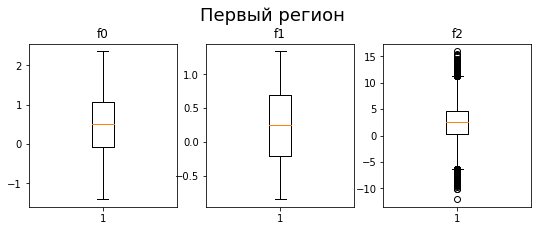

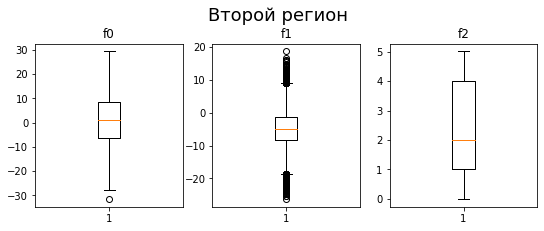

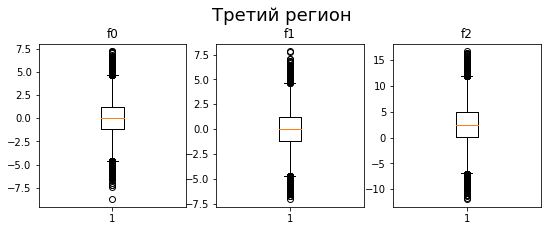

In [6]:
boxplot(df_0, 'Первый регион')
boxplot(df_1, 'Второй регион')
boxplot(df_2, 'Третий регион')

Видим что во всех датасетах есть выбросы, но они не аномально большие, оценим их количественно.

In [7]:
def outliers(df, t, title):
    Q1 = df[t].quantile(0.25)
    Q3 = df[t].quantile(0.75) 
    IQR = Q3 - Q1
    up_lim = Q3 + IQR * 1.5
    low_lim = Q1 - IQR * 1.5
    out = df[t].loc[(df[t] < low_lim )| (df[t] > up_lim)].shape[0] / df[t].shape[0] * 100
    print('Выбросов в', title,':', out,'%')

In [8]:
outliers(df_0, 'f2', 'первом регионе по f2')
outliers(df_1, 'f1', 'втором регионе по f1')
outliers(df_2, 'f0', 'третьем регионе по f0')
outliers(df_2, 'f1', 'третьем регионе по f1')
outliers(df_2, 'f2', 'третьем регионе по f2')

Выбросов в первом регионе по f2 : 0.506 %
Выбросов в втором регионе по f1 : 0.636 %
Выбросов в третьем регионе по f0 : 0.733 %
Выбросов в третьем регионе по f1 : 0.6839999999999999 %
Выбросов в третьем регионе по f2 : 0.584 %


Все выбросы не превышают 1% от всех данных, а значит они не окажут серьезного влияния на обучение нашей модели.

Удалим из датасетов стобец id, он нам не нужен.

In [9]:
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

<a id='Part_2'></a>
# 2. Обучение и проверка модели
Выделим в датасетах целевой признак, далее напишем функцию которая будет разделять входящий датасет на обучающую и валидационную выборку в сотношении 75:25, обучать модель линейной регрессии по обучающей выборке и производить предсказания по валидационной, считать среднеквадратичную ошибку и среднее, а также сохранять полученные предсказания и целевую выборку в соответствующие переменные.

In [10]:
r_state = 123456

In [11]:
df_0_target = df_0['product']
df_0_features = df_0.drop('product', axis=1)
df_1_target = df_1['product']
df_1_features = df_1.drop('product', axis=1)
df_2_target = df_2['product']
df_2_features = df_2.drop('product', axis=1)

In [12]:
def work(features, target, r_state, i):
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=r_state)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    print('Результаты по региону ', i, ':')
    print("RMSE =", mse ** 0.5)
    print("Средний запас сырья =", predicted_valid.mean())
    print("------------------------")
    return (predicted_valid, target_valid)#выгружаем предсказанные и целевые
                                          #значения для валидационной выборки

In [13]:
predict_0, target_0 = work(df_0_features, df_0_target, r_state, 1)
predict_1, target_1 = work(df_1_features, df_1_target, r_state, 2)
predict_2, target_2 = work(df_2_features, df_2_target, r_state, 3)

Результаты по региону  1 :
RMSE = 37.80046993478272
Средний запас сырья = 92.49286560032228
------------------------
Результаты по региону  2 :
RMSE = 0.890493320627005
Средний запас сырья = 69.03055429593262
------------------------
Результаты по региону  3 :
RMSE = 39.98039278339241
Средний запас сырья = 94.84835708988288
------------------------


### Вывод
По результатам данного шага мы видим, что линейная регрессия имеет высокую среднеквадратичную ошибку для первого и третьего региона, это надо учитывать в дальнейших выводах.

<a id='Part_3'></a>
# 3. Подготовка к расчёту прибыли
Заведем константы для расчета прибыли и расчитаем достаточный объём сырья для безубыточной разработки региона

In [14]:
BUDGET = 10e9
BARREL_COST = 450
PROD_COST = BARREL_COST * 1000
N_DRILLS = 200

In [15]:
profit_limit = BUDGET / N_DRILLS / BARREL_COST / 1000
profit_limit

111.11111111111111

In [16]:
print(predict_0.mean() - profit_limit)
print()
print(predict_1.mean() - profit_limit)
print()
print(predict_2.mean() - profit_limit)

-18.61824551078884

-42.0805568151785

-16.262754021228233


### Вывод
Для безубыточной разработки региона необходимо получать 111 тыс. баррелей нефти, как видим с цифр выше, в среднем ни один регион не может обеспечить безубыточность.

<a id='Part_4'></a>
# 4. Расчёт прибыли и рисков 
Напишем функцию которая считает прибыль по 200 лучшим вышкам. 

In [17]:
def revenue(predict, target):
    best_drills_index = pd.Series(predict).sort_values(ascending=False)[:200].index #находим индексы 200 лучших вышек среди предсказаний
    income = target.reset_index(drop=True)[best_drills_index].sum() * PROD_COST #находим сумму истинных значения вышек по индексам от предсказаний 
                                                                                #и умножаем на стоимость продукта
    return income - BUDGET # считаем прибыль

Рассчитаем максимальную прибыль с каждого региона.

In [18]:
revenue(predict_0, target_0)

3491186901.763096

In [19]:
revenue(predict_1, target_1)

2415086696.681511

In [20]:
revenue(predict_2, target_2)

2405061690.317089

Применяя технику Bootstrap с 1000 выборок, найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

In [21]:
state = np.random.RandomState(r_state)
def bootstrap(predict, target):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n = 500,
                                                                replace=True, random_state = state)
        predict_subsample = predict[target_subsample.index]
    
        values.append(revenue(predict_subsample, target_subsample))

    values = pd.Series(values)
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    loss = (values < 0).sum() / 10
    print("Средняя прибыль: ", values.mean())
    print("Доверительный интервал: ", confidence_interval)
    print("Риск убытков: ", loss, "%")

In [22]:
bootstrap(predict_0, target_0)

Средняя прибыль:  484679223.5403135
Доверительный интервал:  (-5476874.350352755, 984467700.7303221)
Риск убытков:  2.7 %


In [23]:
bootstrap(predict_1, target_1)

Средняя прибыль:  449277950.53947204
Доверительный интервал:  (30327988.767628387, 847277702.3099976)
Риск убытков:  1.4 %


In [24]:
bootstrap(predict_2, target_2)

Средняя прибыль:  364219602.3450254
Доверительный интервал:  (-122525091.00040863, 857751530.9950156)
Риск убытков:  7.2 %


### Вывод
Средняя прибыль оказалась максимальной у первого региона, затем идет второй и третий.
Первый и второй регион имеют отрицательные величины в доверительном интервале, соответственно у них риск убытка выше.
Но учитывая полученные оценки по среднеквадратичной ошибке, то можно сделать вывод, что лучшим регионом для разработки будет второй, поскольку у него самая низкая среднеквадратичная ошибка, самый низкий риск убытка и достаточно высокая прибыль. 